World bounds (excluding Antarctica): [-179.99998854  -58.49860904  179.99998854   83.62360016]
Processing Field Capacity (mm/mm) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.04 - 0.66
Processing Wilting Point (mm/mm) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.01 - 0.46
Processing Available Water Capacity (mm/mm) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.00 - 0.40
Processing Effective Plant Rooting Depth (m) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.00 - 126.11
Processing Water Holding Capacity (mm) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.00 - 21079.29


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


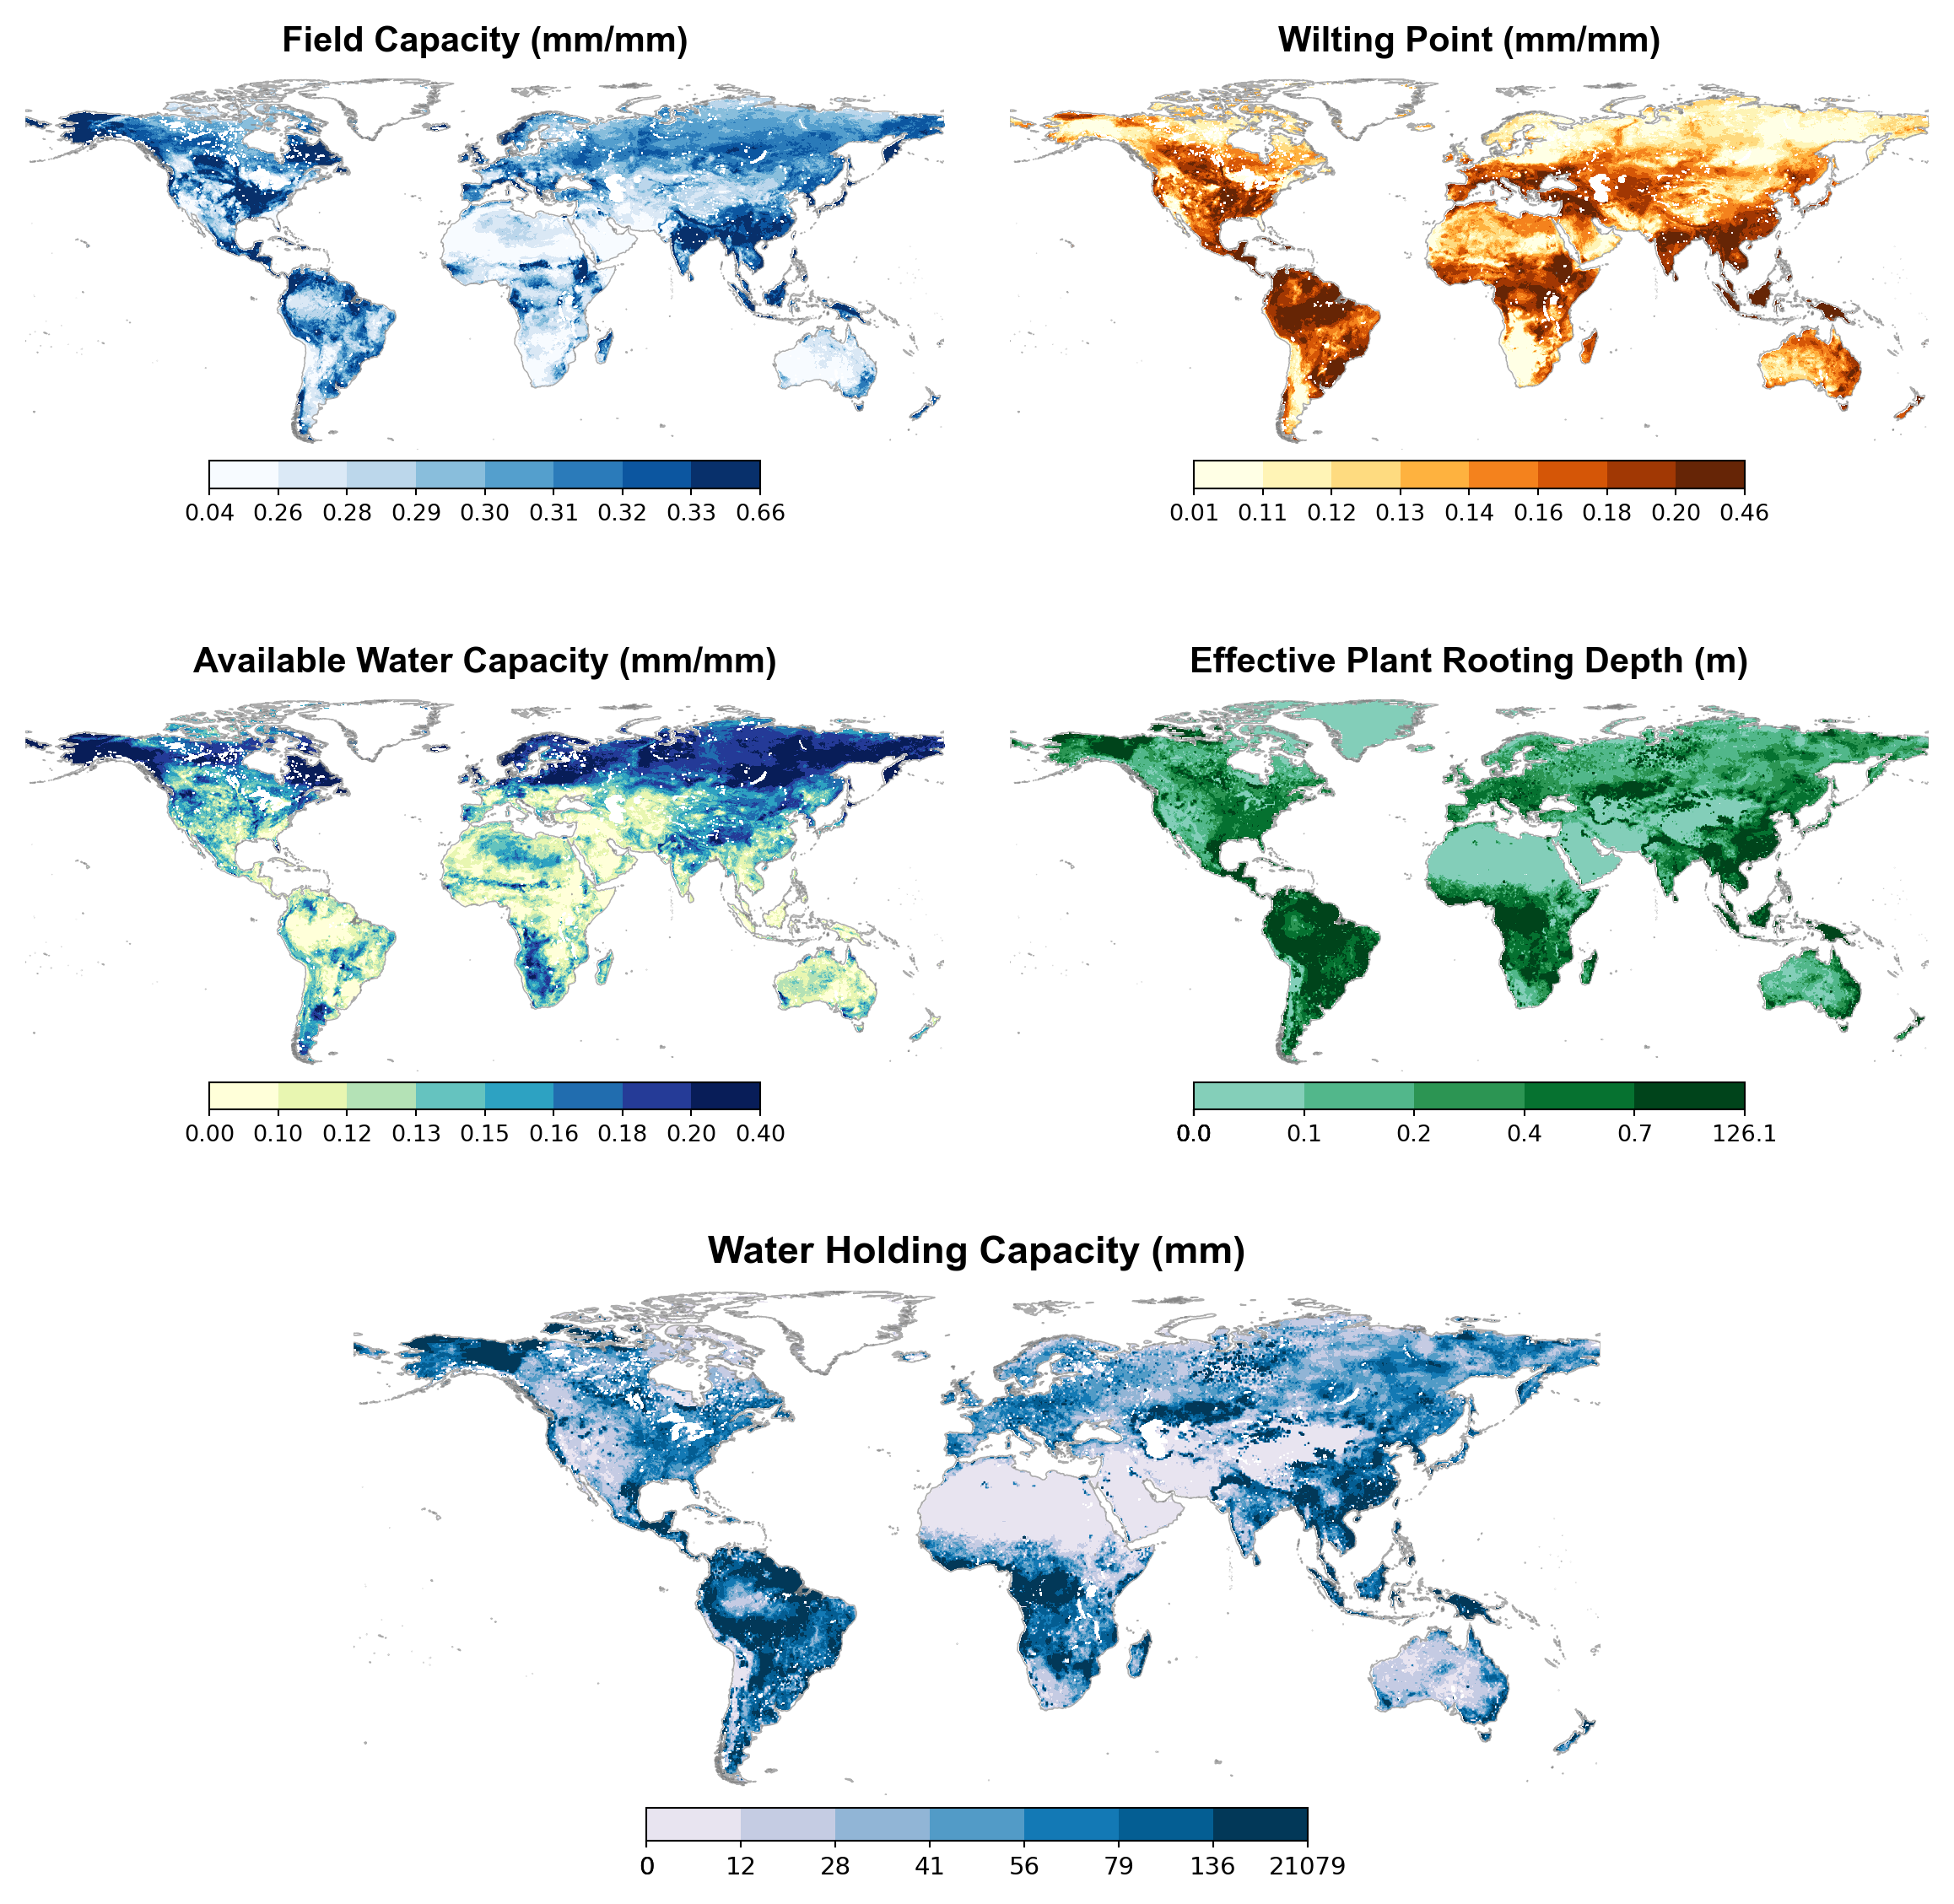

In [2]:
import rasterio
from rasterio.enums import Resampling
from affine import Affine
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import BoundaryNorm
import numpy as np

# ==============================================
# ⚙️ RASTER HANDLING UTILITIES
# ==============================================

def load_and_resample_raster(path, max_pixels=4096 * 4096):
    """Load and optionally resample raster to avoid memory issues while preserving data range."""
    with rasterio.open(path) as src:
        width, height = src.width, src.height
        total_pixels = width * height
        scale = 1.0
        if total_pixels > max_pixels:
            scale = (max_pixels / float(total_pixels)) ** 0.5
        out_width, out_height = max(1, int(width * scale)), max(1, int(height * scale))
        
        # Use bilinear resampling to better preserve data characteristics
        data = src.read(
            1,
            out_shape=(out_height, out_width),
            resampling=Resampling.bilinear
        )
        new_transform = src.transform * Affine.scale(width / out_width, height / out_height)
        nodata = src.nodata
        
        # Get original data statistics for reference
        original_min = src.statistics(1).min
        original_max = src.statistics(1).max
        
    return data, new_transform, nodata, original_min, original_max


def get_valid_data(data, nodata):
    """Return valid (non-nodata) values."""
    mask = data != nodata if nodata is not None else ~np.isnan(data)
    return data[mask]


def auto_bins_quantile(data, nodata, num_bins=7, original_min=None, original_max=None):
    """Create automatic bin intervals based on quantiles (equal count)."""
    valid = get_valid_data(data, nodata)
    if len(valid) == 0:
        return np.linspace(0, 1, num_bins)
    
    # Use original min/max if available, otherwise compute from resampled data
    vmin = original_min if original_min is not None else np.nanmin(valid)
    vmax = original_max if original_max is not None else np.nanmax(valid)
    
    # Use quantiles from the resampled data for bin distribution
    quantiles = np.linspace(0, 100, num_bins)
    bins = np.percentile(valid, quantiles)
    
    # Ensure bins span the full original range
    bins[0] = vmin
    bins[-1] = vmax
    
    # Ensure unique bins
    bins = np.unique(bins)
    
    # If we have fewer unique bins than requested, fill with linspace
    if len(bins) < num_bins:
        if vmin == vmax:
            vmax = vmin + 1
        bins = np.linspace(vmin, vmax, num_bins)
    
    return bins


def auto_bins_logarithmic(data, nodata, num_bins=7, original_min=None, original_max=None):
    """Create logarithmic bins for data with heavy skew toward low values."""
    valid = get_valid_data(data, nodata)
    if len(valid) == 0:
        return np.linspace(0, 1, num_bins)
    
    # Use original min/max if available
    vmin = original_min if original_min is not None else np.nanmin(valid)
    vmax = original_max if original_max is not None else np.nanmax(valid)
    
    # Handle zero or negative values by adding offset
    offset = 0
    if vmin <= 0:
        offset = abs(vmin) + 1
        vmin += offset
        vmax += offset
    
    # Create logarithmic bins
    log_min = np.log10(vmin)
    log_max = np.log10(vmax)
    log_bins = np.linspace(log_min, log_max, num_bins)
    bins = 10 ** log_bins
    
    # Remove offset if it was added
    if offset > 0:
        bins -= offset
    
    return bins


def auto_bins_natural_breaks(data, nodata, num_bins=9, original_min=None, original_max=None):
    """Create bins using natural breaks (Jenks) approach - simplified version."""
    valid = get_valid_data(data, nodata)
    if len(valid) == 0:
        return np.linspace(0, 1, num_bins)
    
    # Use original min/max if available
    vmin = original_min if original_min is not None else np.nanmin(valid)
    vmax = original_max if original_max is not None else np.nanmax(valid)
    
    # Sample data if too large for efficient processing
    if len(valid) > 10000:
        sample_indices = np.random.choice(len(valid), 10000, replace=False)
        valid = valid[sample_indices]
    
    # Sort the data
    sorted_data = np.sort(valid)
    
    # Use histogram to find natural breaks
    hist, edges = np.histogram(sorted_data, bins=num_bins*3)
    
    # Find valleys in the histogram (local minima)
    valleys = []
    for i in range(1, len(hist)-1):
        if hist[i] < hist[i-1] and hist[i] < hist[i+1]:
            valleys.append(edges[i])
    
    # If we have enough valleys, use them
    if len(valleys) >= num_bins - 1:
        bins = [vmin] + sorted(valleys)[:num_bins-2] + [vmax]
        bins = np.array(bins)
    else:
        # Fall back to quantiles if not enough valleys found
        quantiles = np.linspace(0, 100, num_bins)
        bins = np.percentile(sorted_data, quantiles)
        bins[0] = vmin
        bins[-1] = vmax
    
    return bins


# ==============================================
# 🗺️ PLOTTING UTILITIES
# ==============================================

def plot_raster(ax, data, transform, nodata, var_name, cmap, world, original_min, original_max, 
                bin_method='quantile', world_bounds=None, is_main=False):
    """Plot raster with auto-generated discrete legend bins."""
    if bin_method == 'logarithmic':
        bins = auto_bins_logarithmic(data, nodata, original_min=original_min, original_max=original_max)
    elif bin_method == 'natural_breaks':
        bins = auto_bins_natural_breaks(data, nodata, original_min=original_min, original_max=original_max)
    else:  # default to quantile
        bins = auto_bins_quantile(data, nodata, original_min=original_min, original_max=original_max)
    
    norm = BoundaryNorm(bins, ncolors=plt.get_cmap(cmap).N, extend="neither")
    
    masked = np.ma.masked_equal(data, nodata) if nodata is not None else data
    
    extent = [
        transform[2],
        transform[2] + transform[0] * data.shape[1],
        transform[5] + transform[4] * data.shape[0],
        transform[5]
    ]
    
    im = ax.imshow(masked, cmap=cmap, norm=norm, extent=extent, 
                   aspect='auto', interpolation='bilinear')
    
    # Line width and alpha for professional appearance
    world.plot(ax=ax, edgecolor='grey', facecolor='none', 
               linewidth=0.4 if is_main else 0.35, alpha=0.65)
    
    # Set axis limits to world bounds (excluding Antarctica)
    if world_bounds is not None:
        minx, miny, maxx, maxy = world_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
    
    # Professional title formatting for publication
    title_size = 11 if is_main else 10
    ax.set_title(var_name, fontsize=title_size, fontweight='bold', pad=8, 
                 fontname='Arial')
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    return im, norm, bins


def add_colorbar(fig, ax, im, bins, is_main=False):
    """Attach discrete colorbar with smart decimal formatting."""
    # Smaller, more proportional colorbar
    cbar = fig.colorbar(
        im, ax=ax, orientation='horizontal',
        pad=0.02, fraction=0.05, shrink=1.0,
        ticks=bins, extend='neither'
    )
    
    # Smart formatting: 2 decimals only if max value < 1, otherwise integer/1 decimal
    data_range = bins[-1] - bins[0]
    max_val = bins[-1]
    
    if max_val < 1:
        # Values less than 1: use 2 decimals
        labels = [f'{tick:.2f}' for tick in bins]
    elif max_val < 150:
        # Values between 1-10: use 1 decimal
        labels = [f'{tick:.1f}' for tick in bins]
    else:
        # Values >= 10: use integers
        labels = [f'{int(round(tick))}' for tick in bins]
    
    cbar.set_ticklabels(labels)
    
    # Compact label sizing
    label_size = 7 if is_main else 6.5
    cbar.ax.tick_params(labelsize=label_size, length=2, width=0.5, pad=2)
    
    # Remove colorbar outline for cleaner look
    cbar.outline.set_linewidth(0.5)
    
    return cbar


# ==============================================
# 🚀 MAIN EXECUTION
# ==============================================

def main():
    # Load world boundaries
    #world = gpd.read_file("Z:/PhD_Datasets&Analysis/Info_Inputs/Reference_Layers/World_Countries_Generalized_WGS84.shp")
    world = gpd.read_file("Z:/PhD_Datasets&Analysis/Info_Inputs/Reference_Layers/World_Generalized_WGS84.shp")
    
    # Filter out Antarctica
    for col in ['CONTINENT', 'continent', 'Continent', 'COUNTRY', 'Country', 'NAME', 'name']:
        if col in world.columns:
            world = world[world[col] != 'Antarctica']
            break
    
    # Get the bounds of the world (excluding Antarctica)
    world_bounds = world.total_bounds  # returns (minx, miny, maxx, maxy)
    print(f"World bounds (excluding Antarctica): {world_bounds}")
    
    # File paths and titles
    geotiff_paths = [
        'Z:/PhD_Datasets&Analysis/Info_Inputs/SoilGrids/Vol_Water_Content/33kPa/FC33_WGS84.tif',
        'Z:/PhD_Datasets&Analysis/Info_Inputs/SoilGrids/Vol_Water_Content/1500kPa/WP_WGS84.tif',
        'Z:/PhD_Datasets&Analysis/Info_Inputs/SoilGrids/AWC_Standard_Method/Only_Positive_Values/AWC_FC33_WGS84.tif',
        'Z:/PhD_Datasets&Analysis/Info_Inputs/Global_effective_plant_rooting_depth/data/Effective_Rooting_Depth_With_Zeros_Clipped.tif',
        'Z:/PhD_Datasets&Analysis/Info_Inputs/Water_Holding_Capacity/WHC_FC33_WGS84.tif'
    ]
    
    names = [
        'Field Capacity (mm/mm)',
        'Wilting Point (mm/mm)',
        'Available Water Capacity (mm/mm)',
        'Effective Plant Rooting Depth (m)',
        'Water Holding Capacity (mm)'
    ]
    
    colormaps = ['Blues', 'YlOrBr', 'YlGnBu', 'BuGn', 'PuBu']
    
    # Define classification methods for each variable
    bin_methods = ['natural_breaks', 'natural_breaks', 'natural_breaks', 'natural_breaks', 'natural_breaks']
    
    # Larger figure dimensions for better map-to-colorbar ratio
    fig = plt.figure(figsize=(8, 8), dpi=300)  # Increased width from 7.2 to 9
    
    # Create grid with reduced vertical spacing
    gs = GridSpec(3, 6, figure=fig, 
                  hspace=0.12, wspace=0.25,  # Reduced wspace for more map space
                  height_ratios=[1.5, 1.5, 1.8],
                  left=0.04, right=0.98, top=0.97, bottom=0.03)  # Maximized plotting area
    
    axes = [
        fig.add_subplot(gs[0, 0:3]),  # Row 1, left
        fig.add_subplot(gs[0, 3:6]),  # Row 1, right
        fig.add_subplot(gs[1, 0:3]),  # Row 2, left
        fig.add_subplot(gs[1, 3:6]),  # Row 2, right
        fig.add_subplot(gs[2, 1:5])   # Row 3, centered
    ]
    
    # Plot all rasters
    for idx, (ax, path, var_name, cmap, bin_method) in enumerate(zip(axes, geotiff_paths, names, colormaps, bin_methods)):
        is_main = (idx == 4)  # Last map is the main one
        print(f"Processing {var_name} with {bin_method} classification...")
        data, transform, nodata, original_min, original_max = load_and_resample_raster(path)
        im, norm, bins = plot_raster(ax, data, transform, nodata, var_name, cmap, world, 
                                     original_min, original_max, bin_method=bin_method,
                                     world_bounds=world_bounds, is_main=is_main)
        add_colorbar(fig, ax, im, bins, is_main=is_main)
        print(f"  Original range: {original_min:.2f} - {original_max:.2f}")
    
    # Optional: Save the figure for publication
    # plt.savefig('soil_water_capacity_maps.png', dpi=300, bbox_inches='tight', 
    #             facecolor='white', edgecolor='none')
    # plt.savefig('soil_water_capacity_maps.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()


if __name__ == "__main__":
    main()

World bounds (excluding Antarctica): [-179.99998854  -58.49860904  179.99998854   83.62360016]
Processing Monthly Recession Constant (k)...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.11 - 0.90


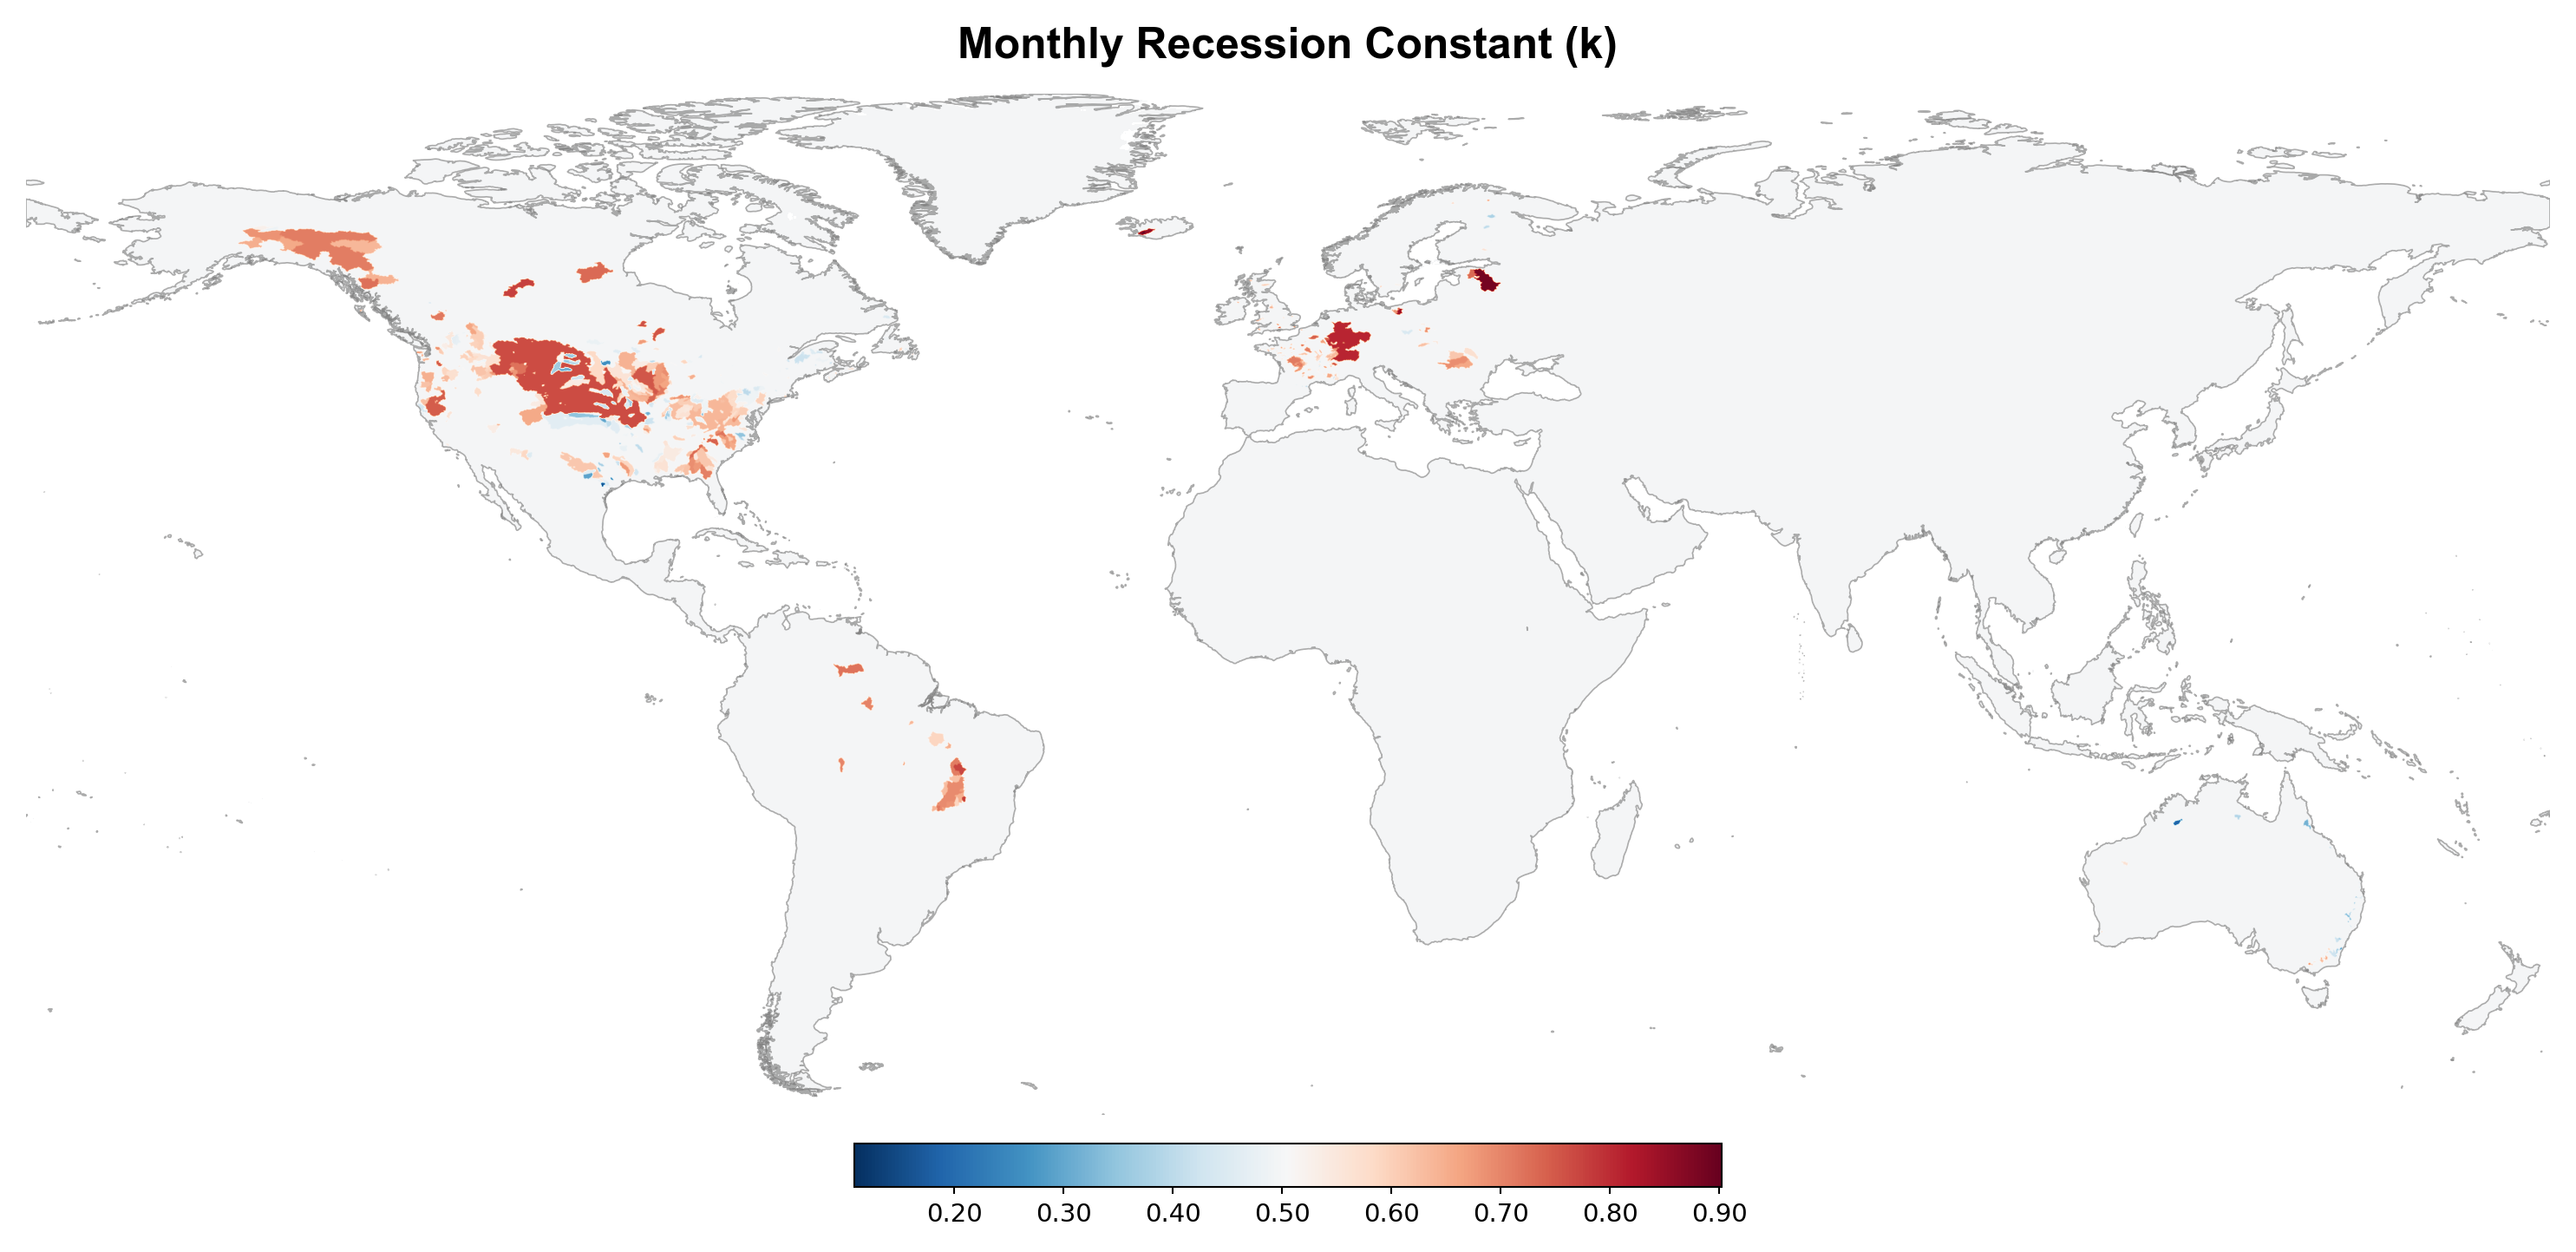

In [11]:
import rasterio
from rasterio.enums import Resampling
from affine import Affine
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# ==============================================
# ⚙️ RASTER HANDLING UTILITIES
# ==============================================

def load_and_resample_raster(path, max_pixels=4096 * 4096):
    """Load and optionally resample raster to avoid memory issues while preserving data range."""
    with rasterio.open(path) as src:
        width, height = src.width, src.height
        total_pixels = width * height
        scale = 1.0
        if total_pixels > max_pixels:
            scale = (max_pixels / float(total_pixels)) ** 0.5
        out_width, out_height = max(1, int(width * scale)), max(1, int(height * scale))
        
        # Use bilinear resampling to better preserve data characteristics
        data = src.read(
            1,
            out_shape=(out_height, out_width),
            resampling=Resampling.bilinear
        )
        new_transform = src.transform * Affine.scale(width / out_width, height / out_height)
        nodata = src.nodata
        
        # Get original data statistics for reference
        original_min = src.statistics(1).min
        original_max = src.statistics(1).max
        
    return data, new_transform, nodata, original_min, original_max


def get_valid_data(data, nodata):
    """Return valid (non-nodata) values."""
    mask = data != nodata if nodata is not None else ~np.isnan(data)
    return data[mask]


# ==============================================
# 🗺️ PLOTTING UTILITIES
# ==============================================

def plot_raster(ax, data, transform, nodata, var_name, cmap, world, original_min, original_max, 
                world_bounds=None):
    """Plot raster with continuous color scale."""
    
    masked = np.ma.masked_equal(data, nodata) if nodata is not None else data
    
    extent = [
        transform[2],
        transform[2] + transform[0] * data.shape[1],
        transform[5] + transform[4] * data.shape[0],
        transform[5]
    ]
    
    # Use continuous color scale with vmin/vmax from original data
    im = ax.imshow(masked, cmap=cmap, extent=extent, 
                   aspect='auto', interpolation='bilinear',
                   vmin=original_min, vmax=original_max)
    
    # Line width and alpha for professional appearance
    world.plot(ax=ax, edgecolor='grey', facecolor='none', 
               linewidth=0.4, alpha=0.65)
    
    # Set axis limits to world bounds (excluding Antarctica)
    if world_bounds is not None:
        minx, miny, maxx, maxy = world_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
    
    # Professional title formatting for publication
    ax.set_title(var_name, fontsize=12, fontweight='bold', pad=10, 
                 fontname='Arial')
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    return im


def add_colorbar(fig, ax, im, original_min, original_max):
    """Attach continuous colorbar with smart decimal formatting."""
    # Smaller horizontal colorbar below the map
    cbar = fig.colorbar(
        im, ax=ax, orientation='horizontal',
        pad=0.02, fraction=0.03, shrink=0.6  # Reduced size: smaller fraction and shrink
    )
    
    # Smart formatting: 2 decimals only if max value < 1, otherwise integer/1 decimal
    max_val = original_max
    
    if max_val < 1:
        # Values less than 1: use 2 decimals
        cbar.ax.ticklabel_format(style='plain', useOffset=False)
        cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
    elif max_val < 150:
        # Values between 1-150: use 1 decimal
        cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
    else:
        # Values >= 150: use integers
        cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(round(x))}'))
    
    # Smaller label sizing
    cbar.ax.tick_params(labelsize=7, length=2, width=0.5, pad=2)
    
    # Thinner colorbar outline
    cbar.outline.set_linewidth(0.5)
    
    return cbar


# ==============================================
# 🚀 MAIN EXECUTION
# ==============================================

def main():
    # Load world boundaries
    world = gpd.read_file("Z:/PhD_Datasets&Analysis/Info_Inputs/Reference_Layers/World_Generalized_WGS84.shp")
    
    # Filter out Antarctica
    for col in ['CONTINENT', 'continent', 'Continent', 'COUNTRY', 'Country', 'NAME', 'name']:
        if col in world.columns:
            world = world[world[col] != 'Antarctica']
            break
    
    # Get the bounds of the world (excluding Antarctica)
    world_bounds = world.total_bounds  # returns (minx, miny, maxx, maxy)
    print(f"World bounds (excluding Antarctica): {world_bounds}")
    
    # ===== CONFIGURE YOUR MAP HERE =====
    raster_path = 'Z:\\PhD_Datasets&Analysis\\Inputs\\monthly_k_recession_all_FINAL.tif'
    map_title = 'Monthly Recession Constant (k)'
    colormap = 'RdBu_r'
    
    # Create single map figure
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
    # Plot the raster
    print(f"Processing {map_title}...")
    data, transform, nodata, original_min, original_max = load_and_resample_raster(raster_path)
    im = plot_raster(ax, data, transform, nodata, map_title, colormap, world, 
                     original_min, original_max, world_bounds=world_bounds)
    add_colorbar(fig, ax, im, original_min, original_max)
    print(f"  Original range: {original_min:.2f} - {original_max:.2f}")
    
    # Adjust layout
    plt.tight_layout()
    
    # Optional: Save the figure for publication
    # plt.savefig('map_output.png', dpi=300, bbox_inches='tight', 
    #             facecolor='white', edgecolor='none')
    # plt.savefig('map_output.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()


if __name__ == "__main__":
    main()

Loading Monthly Recession Constant (k)...
  Original range: 0.11 - 0.90
Processing North America...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


Processing Europe...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


Processing South America...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


Processing Oceania...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


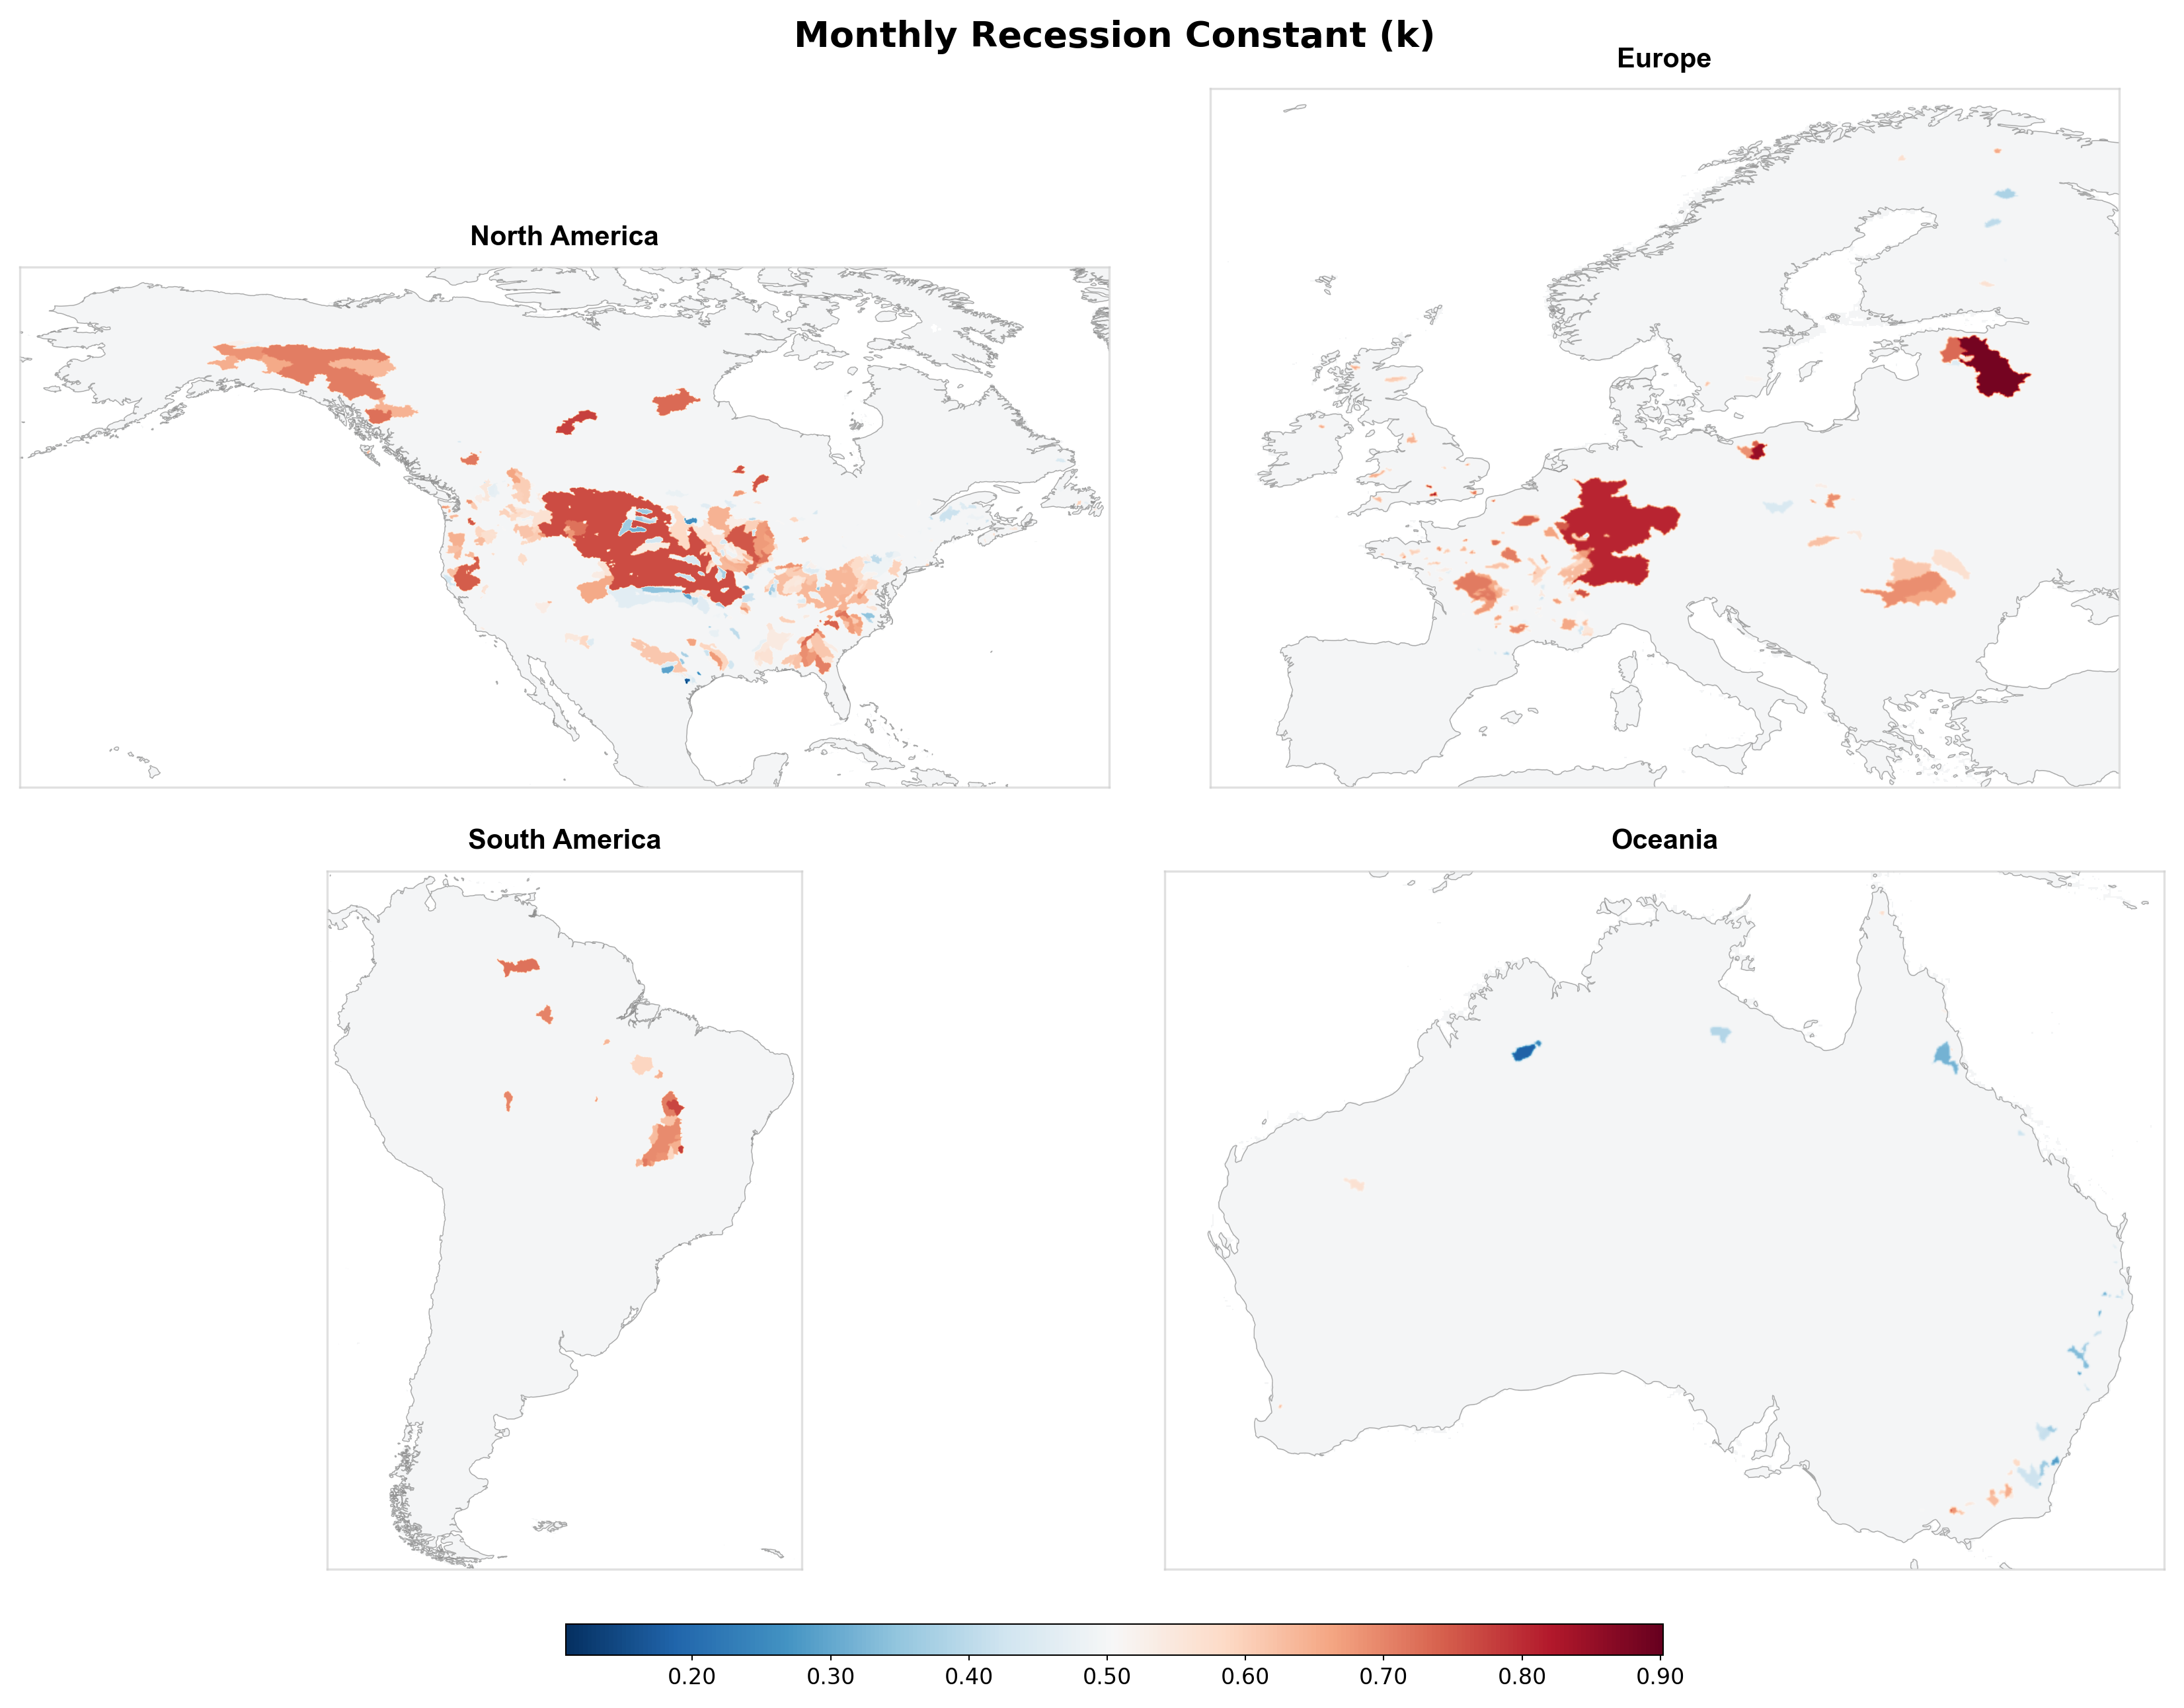

In [22]:
import rasterio
from rasterio.enums import Resampling
from affine import Affine
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# ==============================================
# ⚙️ RASTER HANDLING UTILITIES
# ==============================================

def load_and_resample_raster(path, max_pixels=4096 * 4096):
    """Load and optionally resample raster to avoid memory issues while preserving data range."""
    with rasterio.open(path) as src:
        width, height = src.width, src.height
        total_pixels = width * height
        scale = 1.0
        if total_pixels > max_pixels:
            scale = (max_pixels / float(total_pixels)) ** 0.5
        out_width, out_height = max(1, int(width * scale)), max(1, int(height * scale))
        
        # Use bilinear resampling to better preserve data characteristics
        data = src.read(
            1,
            out_shape=(out_height, out_width),
            resampling=Resampling.bilinear
        )
        new_transform = src.transform * Affine.scale(width / out_width, height / out_height)
        nodata = src.nodata
        
        # Get original data statistics for reference
        original_min = src.statistics(1).min
        original_max = src.statistics(1).max
        
    return data, new_transform, nodata, original_min, original_max


def get_valid_data(data, nodata):
    """Return valid (non-nodata) values."""
    mask = data != nodata if nodata is not None else ~np.isnan(data)
    return data[mask]


# ==============================================
# 🌎 REGION DEFINITIONS
# ==============================================

def get_region_bounds(region_name):
    """Return bounds for specific regions: (minx, miny, maxx, maxy)."""
    regions = {
        'North America': (-170, 18, -52, 73),
        'Europe': (-13, 36, 35, 72),
        'South America': (-82, -56, -34, 13),
        'Oceania': (111, -40, 155, -10)
    }
    return regions.get(region_name)


def filter_world_by_region(world, region_name):
    """Filter world boundaries to include only countries in the specified region."""
    # Define continents for each region
    region_continents = {
        'North America': ['North America'],
        'Europe': ['Europe'],
        'South America': ['South America'],
        'Oceania': ['Oceania']
    }
    
    continents = region_continents.get(region_name, [])
    
    # Try to filter by continent column
    for col in ['CONTINENT', 'continent', 'Continent']:
        if col in world.columns:
            return world[world[col].isin(continents)]
    
    # If no continent column, return full world (will be clipped by bounds)
    return world


# ==============================================
# 🗺️ PLOTTING UTILITIES
# ==============================================

def plot_raster(ax, data, transform, nodata, region_name, cmap, world, vmin, vmax, 
                region_bounds=None):
    """Plot raster with continuous color scale for a specific region."""
    
    masked = np.ma.masked_equal(data, nodata) if nodata is not None else data
    
    extent = [
        transform[2],
        transform[2] + transform[0] * data.shape[1],
        transform[5] + transform[4] * data.shape[0],
        transform[5]
    ]
    
    # Use continuous color scale with common vmin/vmax
    im = ax.imshow(masked, cmap=cmap, extent=extent, 
                   aspect='auto', interpolation='bilinear',
                   vmin=vmin, vmax=vmax)
    
    # Filter and plot world boundaries for this region
    region_world = filter_world_by_region(world, region_name)
    region_world.plot(ax=ax, edgecolor='grey', facecolor='none', 
                      linewidth=0.35, alpha=0.65)
    
    # Set axis limits to region bounds
    if region_bounds is not None:
        minx, miny, maxx, maxy = region_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
    
    # Professional title formatting
    ax.set_title(region_name, fontsize=10, fontweight='bold', pad=8, 
                 fontname='Arial')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add soft frame around each map
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_edgecolor('lightgray')
        spine.set_alpha(0.7)
    
    return im


def add_common_colorbar(fig, axes, im, vmin, vmax):
    """Attach a single, compact colorbar for all subplots."""
    # Smaller colorbar — shorter and thinner than before
    cbar = fig.colorbar(
        im, ax=axes, orientation='horizontal',
        pad=0.035, fraction=0.02, shrink=0.7, aspect=35
    )
    
    # Smart tick formatting
    if vmax < 1:
        cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
    elif vmax < 150:
        cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
    else:
        cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(round(x))}'))
    
    cbar.ax.tick_params(labelsize=8, length=2, width=0.5, pad=2)
    cbar.outline.set_linewidth(0.5)
    
    return cbar


# ==============================================
# 🚀 MAIN EXECUTION
# ==============================================

def main():
    # Load world boundaries (excluding Antarctica)
    world = gpd.read_file("Z:/PhD_Datasets&Analysis/Info_Inputs/Reference_Layers/World_Generalized_WGS84.shp")
    
    for col in ['CONTINENT', 'continent', 'Continent', 'COUNTRY', 'Country', 'NAME', 'name']:
        if col in world.columns:
            world = world[world[col] != 'Antarctica']
            break

    raster_path = 'Z:\\PhD_Datasets&Analysis\\Inputs\\monthly_k_recession_all_FINAL.tif'
    map_title = 'Monthly Recession Constant (k)'
    colormap = 'RdBu_r'
    regions = ['North America', 'Europe', 'South America', 'Oceania']
    
    print(f"Loading {map_title}...")
    data, transform, nodata, original_min, original_max = load_and_resample_raster(raster_path)
    print(f"  Original range: {original_min:.2f} - {original_max:.2f}")

    # ==================================================
    # 📐 Optimized layout (balanced and compact)
    # ==================================================
    fig = plt.figure(figsize=(12, 10), dpi=300)
    
    gs = GridSpec(
        2, 2, figure=fig,
        left=0.04, right=0.96,
        top=0.91, bottom=0.12,
        wspace=0.01,  # 🔹 reduced horizontal space between columns
        hspace=0.12   # 🔹 slightly increased vertical space between rows
    )
    
    axes = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1])
    ]
    
    im = None
    for ax, region_name in zip(axes, regions):
        print(f"Processing {region_name}...")
        region_bounds = get_region_bounds(region_name)
        im = plot_raster(ax, data, transform, nodata, region_name,
                         colormap, world, original_min, original_max,
                         region_bounds=region_bounds)
    
    # Keep original colorbar style and position
    add_common_colorbar(fig, axes, im, original_min, original_max)
    
    # ==================================================
    # 🏷️ Compact main title (closer to subplot titles)
    # ==================================================
    fig.suptitle(
        map_title,
        fontsize=13,
        fontweight='bold',
        y=0.945
    )
    
    # Adjust layout so everything fits within frame
    #plt.subplots_adjust(top=0.90, bottom=0.14)
    
    plt.show()

if __name__ == "__main__":
    main()

In [2]:
import pandas as pd

css_folder = r"Z:\PhD_Datasets&Analysis\Info_Inputs\Streamflow_Stations\Climate_Sensitive_Stations-GRDC"

filtered_css = pd.read_csv(css_folder + "//CSS_FINAL_SELECTION-MERGE_WITH_ALL.csv") # Read file with all CSS information
filtered_css

,station_name,station_no,station_id,station_latitude,station_longitude,station_status,river_name,station_elevation,CATCHMENT_SIZE,NAT_STA_ID,GRDCCOUNTRY,Continent,has_monthly_k,has_daily_k,monthly_k_recession,daily_k_recession,Next_Downstream_Station,CATCHMENT_SIZE2,Priority,Val_Analysis_Monthly_k
0,ABERCROMBIE,5204121,1075206,-33.954800,149.325200,Active,ABERCROMBIE RIVER,426.55,"2631,00 km²",412028,AU - AUSTRALIA,Oceania,Yes,No,0.420650,NaN,5204302,2631.00,432,Yes
1,ABOVE BOULEAU CREEK,4215070,1069050,50.212223,-119.538610,Active,WHITEMAN CREEK,630.00,"112,00 km²",08NM174,CA - CANADA,North America,Yes,Yes,0.350868,0.910436,4215103,112.00,773,Yes
2,"ABOVE CHENEY RESERVOIRE, KS",4125110,1069620,37.863600,-98.014800,Active,NORTH FORK NINNESCAH RIVER,443.80,"2038,30 km²",07144780,US - UNITED STATES,North America,Yes,Yes,0.417039,0.541509,4125801,2038.30,478,No
3,ABOVE FORT MCPHERSON,4208040,1068040,67.248886,-134.883060,Active,PEEL RIVER,NaN,"70600,00 km²",10MC002,CA - CANADA,North America,Yes,Yes,0.625278,0.942386,NaN,70600.00,59,No
4,"ABOVE HAMBURG, IA",4122160,1068596,40.632500,-95.625800,Active,NISHNABOTNA RIVER,272.54,"7267,50 km²",06810000,US - UNITED STATES,North America,Yes,Yes,0.549697,0.912838,4122903,7267.50,264,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,"WOODFORDS, CA (WEST FORK)",4118100,1068421,38.769600,-119.833800,Active,CARSON RIVER,1753.97,"169,38 km²",10310000,US - UNITED STATES,North America,Yes,Yes,0.593689,0.900646,NaN,169.38,732,Yes
805,XAMBIOA,3649418,1071023,-6.409700,-48.542200,Active,RIO ARAGUAIA,118.00,"364500,00 km²",28300000,BR - BRAZIL,South America,Yes,Yes,0.627802,0.974853,3649419,364500.00,20,No
806,XAVANTINA,3649617,1074892,-14.672500,-52.355000,Active,RIO DAS MORTES,266.00,"24950,00 km²",26100000,BR - BRAZIL,South America,Yes,Yes,0.786505,0.977071,3649618,24950.00,123,No
807,"YADKIN COLLEGE, NC",4148321,1069484,35.856700,-80.386900,Active,YADKIN RIVER,194.60,"5905,00 km²",02116500,US - UNITED STATES,North America,Yes,Yes,0.718625,0.896280,4148320,5905.00,294,Yes


In [5]:
# Summary of the stations that passed the validation analysis based on monthly k recessions
final_sts  = filtered_css.loc[filtered_css['Val_Analysis_Monthly_k'] == "Yes"]
final_sts.describe().map(lambda x: f"{x:.2f}")

,station_no,station_id,station_latitude,station_longitude,station_elevation,monthly_k_recession,daily_k_recession,CATCHMENT_SIZE2,Priority
count,588.00,588.00,588.00,588.00,549.00,588.00,575.00,588.00,588.00
mean,4784832.55,1076744.13,36.04,-46.99,313.51,0.56,0.86,11171.99,445.71
std,954369.28,55856.07,22.95,73.07,322.68,0.11,0.10,61432.97,212.88
min,3618720.00,1066120.00,-37.52,-149.69,-1.80,0.11,0.27,49.00,6.00
25%,4122227.50,1068355.75,36.74,-94.52,112.61,0.49,0.83,550.28,267.75
50%,4149380.00,1069476.50,43.62,-80.42,218.71,0.57,0.89,2293.45,450.50
75%,6122140.25,1074019.50,47.25,2.04,404.06,0.64,0.93,7226.10,627.25
max,6870640.00,1584911.00,68.85,153.16,2093.98,0.90,0.99,1357678.00,809.00


In [7]:
# Create statistics of monthly_k_recession grouped by Continent
monthly_k_by_continent = final_sts.groupby('Continent')['monthly_k_recession'].describe()
monthly_k_by_continent

,count,mean,std,min,25%,50%,75%,max
Continent,,,,,,,,
Europe,162.0,0.618112,0.096045,0.380004,0.557209,0.626721,0.670648,0.901778
North America,357.0,0.546510,0.104024,0.108743,0.485694,0.550228,0.616150,0.775657
Oceania,46.0,0.453207,0.138949,0.183405,0.347840,0.421902,0.576881,0.784045
South America,23.0,0.667847,0.051285,0.590999,0.635222,0.660660,0.699860,0.780415
